**Домашнее задание №1, Михалевич Максим Алексеевич, M4122**

Плланирую реалиовать модель для прогнозирования стоимости недвижимости, датасет был найден на Кагле и, на мой взгляд, не является популряным.

**Пункт 1)**
- бизнес постановка: Создать прогнозную модель для определения стоимости недвижимости
- ML-задача: Решить задачу регресии, так как целевая перменная (стоимость квартиры), не имеет четкой дискретизации
- Набор данных содержит 200.000 строк, а также 25 признаков, однако не все они являются релевантными задаче, что можно выявить при поверхностном анализе доменной области.

**Пункт 2)**
- В качестве метрики для оценки качества решения ML задачи планируется использовать MAPE (значений таргета в районе 0 в датасете не наблюдается, в силу исследуемой области, это обезопасит от деления на числа близкие к 0, что является слабым местом MAPE). Данная метрика имеет понятную для бизнеса интерпретацию, также она позволила бы потенциальному заказчику посторить некие доверительные интервалы, в которых может находиться прогноз модели, что, например, позволило бы с случае некоректного прогноза иметь заготовленные финансовые резервы для покрытия издержек в результате ошибочного прогноза.

Пункт 3) EDA
---



In [1]:
!pip install kagglehub phik sweetviz

In [2]:
import warnings
warnings.filterwarnings('ignore')

import phik
import seaborn as sns
import sweetviz as sv
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [3]:
file_path = 'global_house_purchase_dataset.csv'

data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mohankrishnathalla/global-house-purchase-decision-dataset",
  file_path
)

Using Colab cache for faster access to the 'global-house-purchase-decision-dataset' dataset.


In [4]:
data.head()

,property_id,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,...,customer_salary,loan_amount,loan_tenure_years,monthly_expenses,down_payment,emi_to_income_ratio,satisfaction_score,neighbourhood_rating,connectivity_score,decision
0,1,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,...,10745,193949,15,6545,218986,0.16,1,5,6,0
1,2,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,...,16970,181465,20,8605,43073,0.08,9,1,2,0
2,3,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,...,21914,307953,30,2510,437151,0.09,6,8,1,0
3,4,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,...,17980,674720,15,8805,436239,0.33,2,6,6,0
4,5,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,...,17676,65833,25,8965,33208,0.03,3,3,4,0


In [5]:
data.columns

Index(['property_id', 'country', 'city', 'property_type', 'furnishing_status',
       'property_size_sqft', 'price', 'constructed_year', 'previous_owners',
       'rooms', 'bathrooms', 'garage', 'garden', 'crime_cases_reported',
       'legal_cases_on_property', 'customer_salary', 'loan_amount',
       'loan_tenure_years', 'monthly_expenses', 'down_payment',
       'emi_to_income_ratio', 'satisfaction_score', 'neighbourhood_rating',
       'connectivity_score', 'decision'],
      dtype='object')

In [6]:
data.shape

(200000, 25)

In [7]:
data['country'].unique()

array(['France', 'South Africa', 'Germany', 'Canada', 'Brazil', 'UAE',
       'Australia', 'UK', 'USA', 'China', 'Singapore', 'India', 'Japan'],
      dtype=object)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   property_id              200000 non-null  int64  
 1   country                  200000 non-null  object 
 2   city                     200000 non-null  object 
 3   property_type            200000 non-null  object 
 4   furnishing_status        200000 non-null  object 
 5   property_size_sqft       200000 non-null  int64  
 6   price                    200000 non-null  int64  
 7   constructed_year         200000 non-null  int64  
 8   previous_owners          200000 non-null  int64  
 9   rooms                    200000 non-null  int64  
 10  bathrooms                200000 non-null  int64  
 11  garage                   200000 non-null  int64  
 12  garden                   200000 non-null  int64  
 13  crime_cases_reported     200000 non-null  int64  
 14  lega

Из первичного анализа можно заключить, что в представленном наборе данных отсутвуют пропущенные значения, датасет содержит 200000 сэмлов и 25 признаков, также можно отменить наличие 4 категориальных признаков. Далее в ходе проведения EDA необоходимо будет рзаработать варианты их кодирования.

Для решения задачи прогнозирования стоимости жилья, логичным вариантом будет - принять признак price в качестве целевой переменной.
Также исследуемый датасет давольно обширен и обладает признаками, которые не будут иметь влияния на стоиомость жилья, так данный датасет направлен на решении задачи классификации успеха/неуспеха сделки купли продажи.

Справедливо будет на первом этапе исключить из рассмотрения следующие признаки, составляющие финансовый портрет потенциального клиента:
- customer_salary
- loan_amount
- loan_tenure_years
- monthly_expenses
- down_payment
- emi_to_income_ratio
- connectivity_score
- decision



In [9]:
df = data.copy()
columns_fro_drop = ['property_id',
                    'customer_salary',
                    'loan_amount',
                    'loan_tenure_years',
                    'monthly_expenses',
                    'down_payment',
                    'emi_to_income_ratio',
                    'connectivity_score',
                    'decision']
df = df.drop(columns=columns_fro_drop)
df.head()

,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,bathrooms,garage,garden,crime_cases_reported,legal_cases_on_property,satisfaction_score,neighbourhood_rating
0,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,2,1,1,1,0,1,5
1,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,8,1,1,1,1,9,1
2,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,1,1,1,0,0,6,8
3,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,3,0,1,0,0,2,6
4,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,3,1,1,3,1,3,3


Анализ числовых признаков
-

In [10]:
num_cols = df.select_dtypes(exclude='object')
num_cols.describe()

,property_size_sqft,price,constructed_year,previous_owners,rooms,bathrooms,garage,garden,crime_cases_reported,legal_cases_on_property,satisfaction_score,neighbourhood_rating
count,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,3195.633460,1.215365e+06,1991.487770,3.001370,4.513855,2.760030,0.499350,0.500215,1.229065,0.248920,5.498650,5.505240
std,1613.322287,8.236633e+05,18.494064,2.002198,2.295669,1.840959,0.500001,0.500001,1.185336,0.432388,2.875361,2.870945
min,400.000000,5.628800e+04,1960.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1802.000000,5.659895e+05,1975.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
50%,3190.000000,1.023429e+06,1991.000000,3.000000,5.000000,2.000000,0.000000,1.000000,1.000000,0.000000,5.000000,5.000000
75%,4589.000000,1.725556e+06,2008.000000,5.000000,7.000000,4.000000,1.000000,1.000000,2.000000,0.000000,8.000000,8.000000
max,6000.000000,4.202732e+06,2023.000000,6.000000,8.000000,8.000000,1.000000,1.000000,10.000000,1.000000,10.000000,10.000000


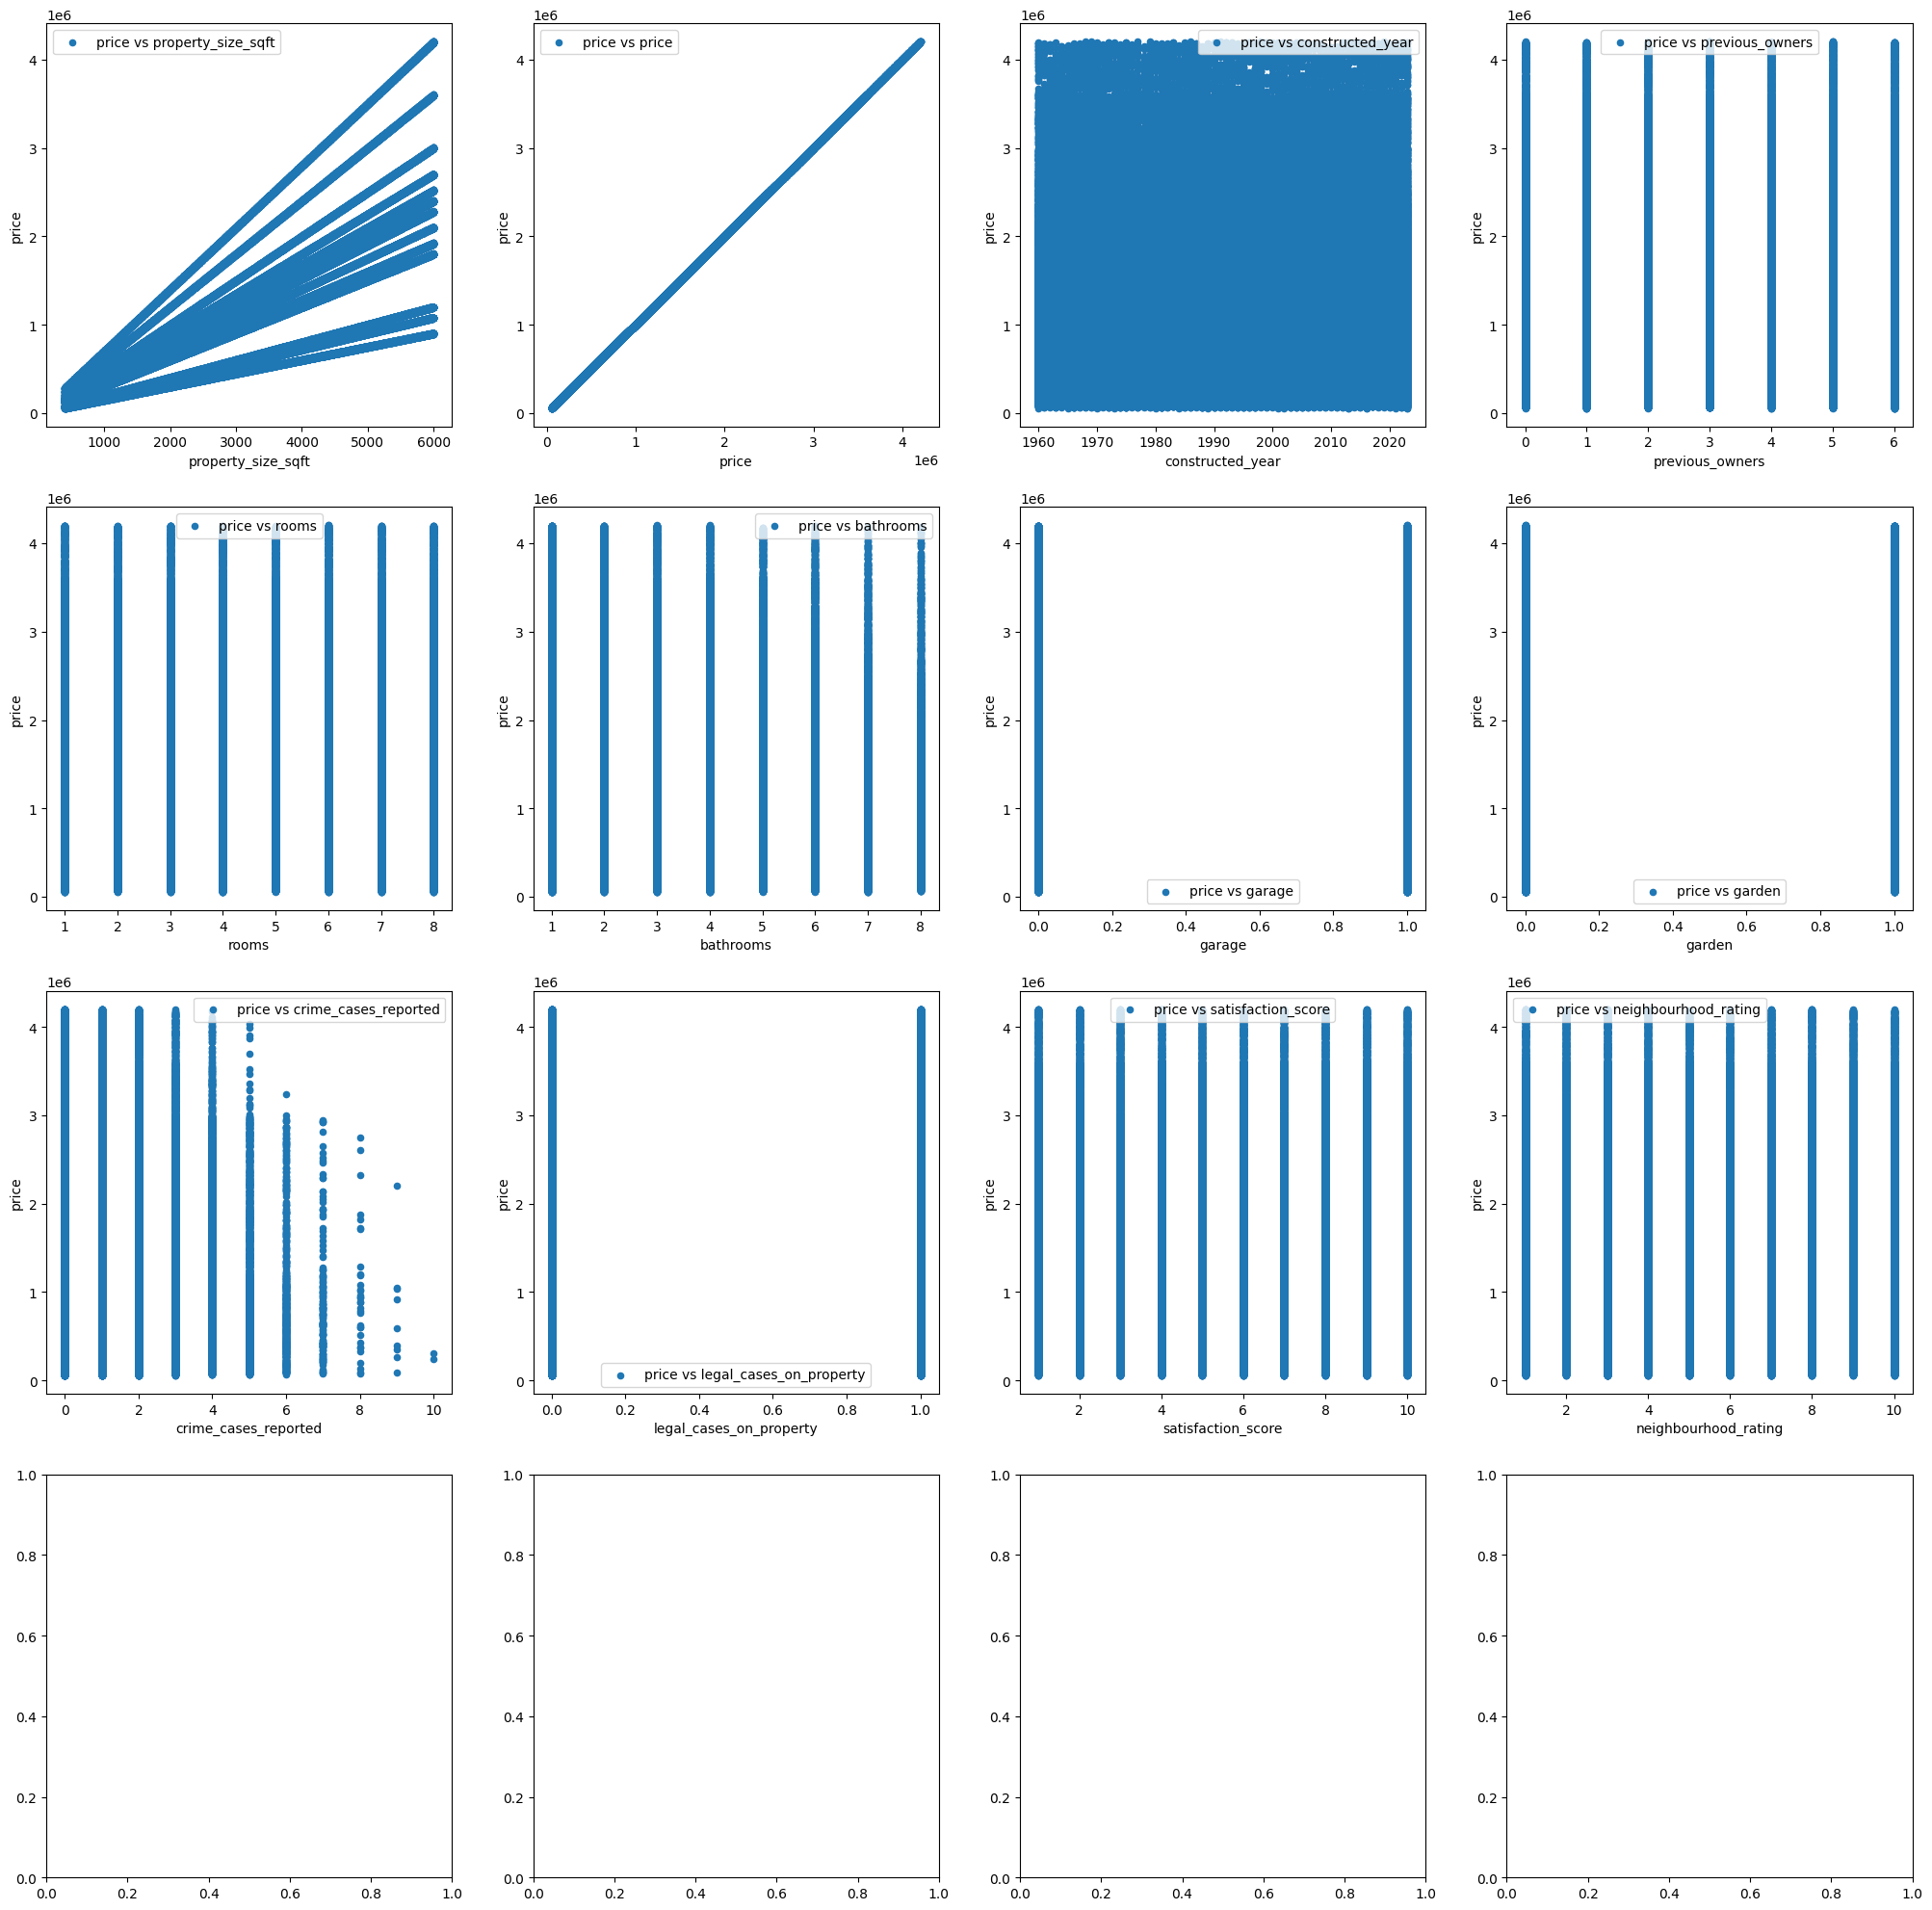

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 25))
for idx, feature in enumerate(num_cols.columns):
    df.plot(feature, "price", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4], label=f'price vs {feature}')

Считаем корреляцию числовых признаков по Пирсону, подтвержим наличие линейной связи признакака property_size_sqft с целевой переменной price и найдем силу этой связи. Также пронаблюдаем и зра другими признаками и их свящью с price

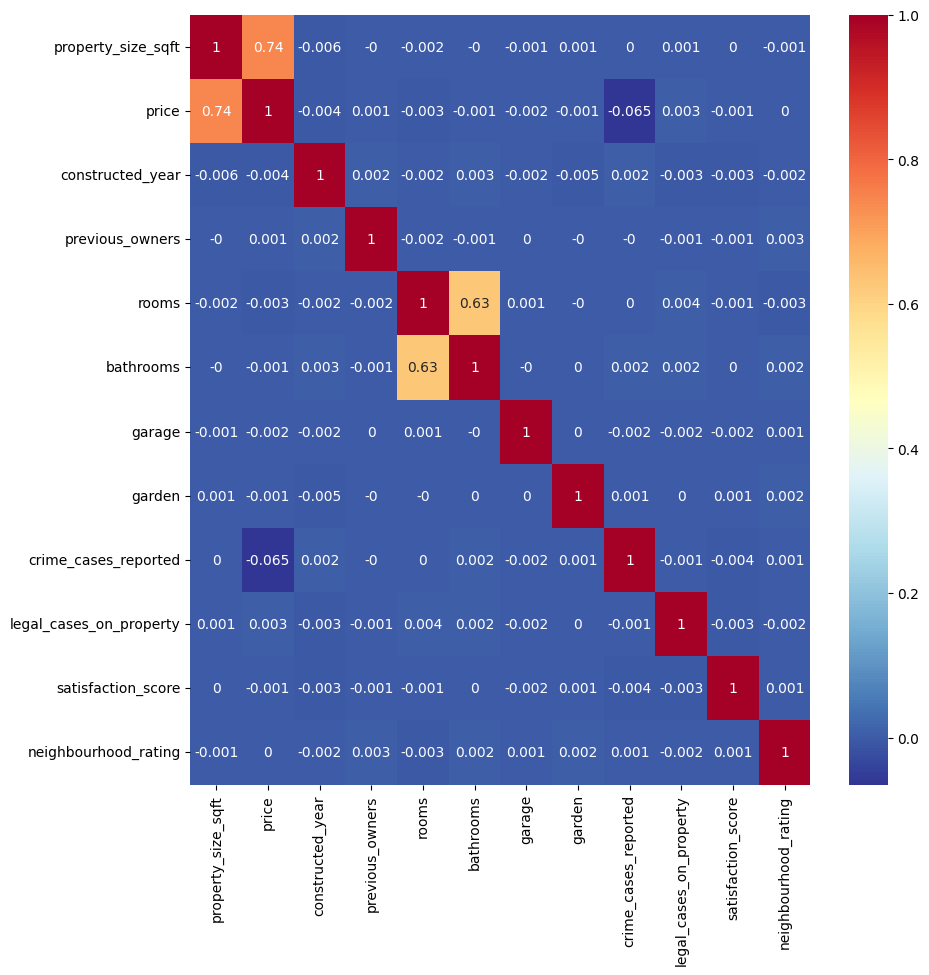

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(num_cols.corr().round(3), cmap="RdYlBu_r", annot=True);

Учтем и нелинейные зависимости, построив матрицу корреляций методом Спирмена

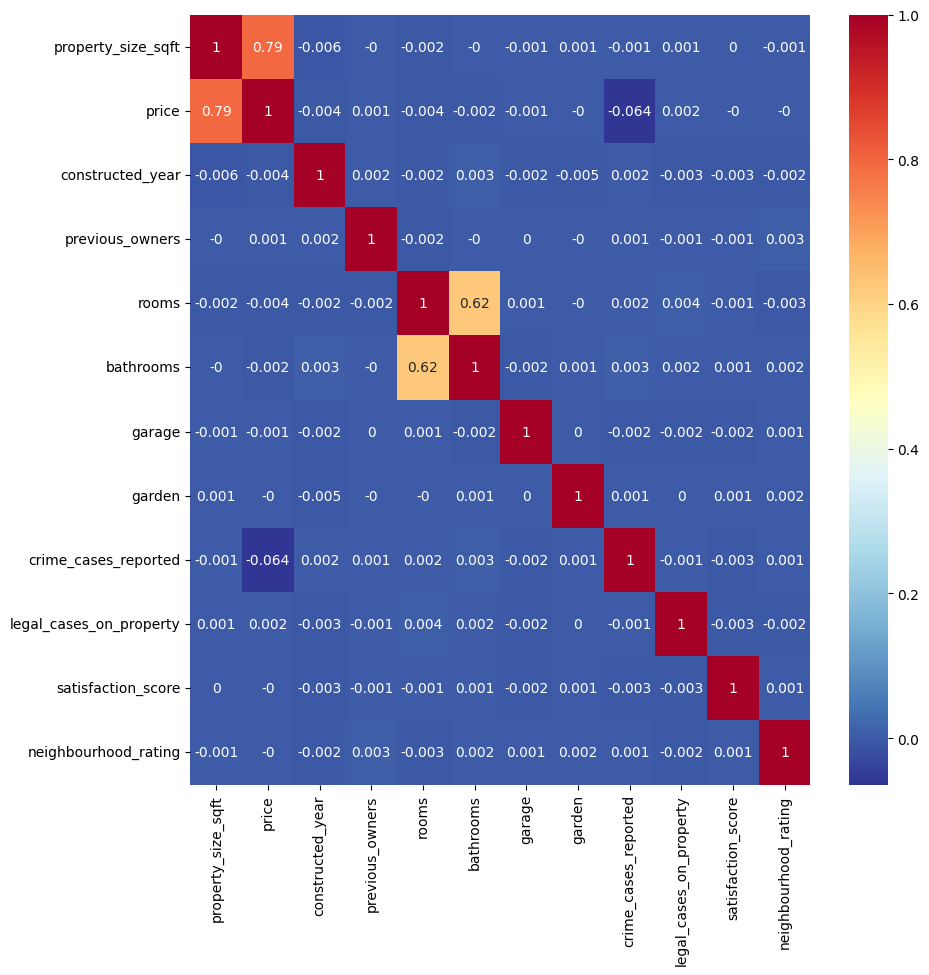

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(num_cols.corr(method='spearman').round(3), cmap="RdYlBu_r", annot=True);

Выводы по анализу числовых признаков: Анализ числовых фичей не дал серьезных резульатов. Удалось установить сильную линейную свзяь между целевой переменной и признаком площади жилья, значения корреляций составило 0,74 и 0,79 по методам Пирсона и Спирмена соответсвенно

Анализ категориальных признаков
-

In [11]:
cat_cols = df.select_dtypes(include='object')
cat_cols['price'] = df['price']
cat_cols.head()

,country,city,property_type,furnishing_status,price
0,France,Marseille,Farmhouse,Semi-Furnished,412935
1,South Africa,Cape Town,Apartment,Semi-Furnished,224538
2,South Africa,Johannesburg,Farmhouse,Semi-Furnished,745104
3,Germany,Frankfurt,Farmhouse,Semi-Furnished,1110959
4,South Africa,Johannesburg,Townhouse,Fully-Furnished,99041


Рассмострим изменяются ли средние значения и межкваритильные размахи целевой переменной в зависимости от страны, в которой находится недвижимость

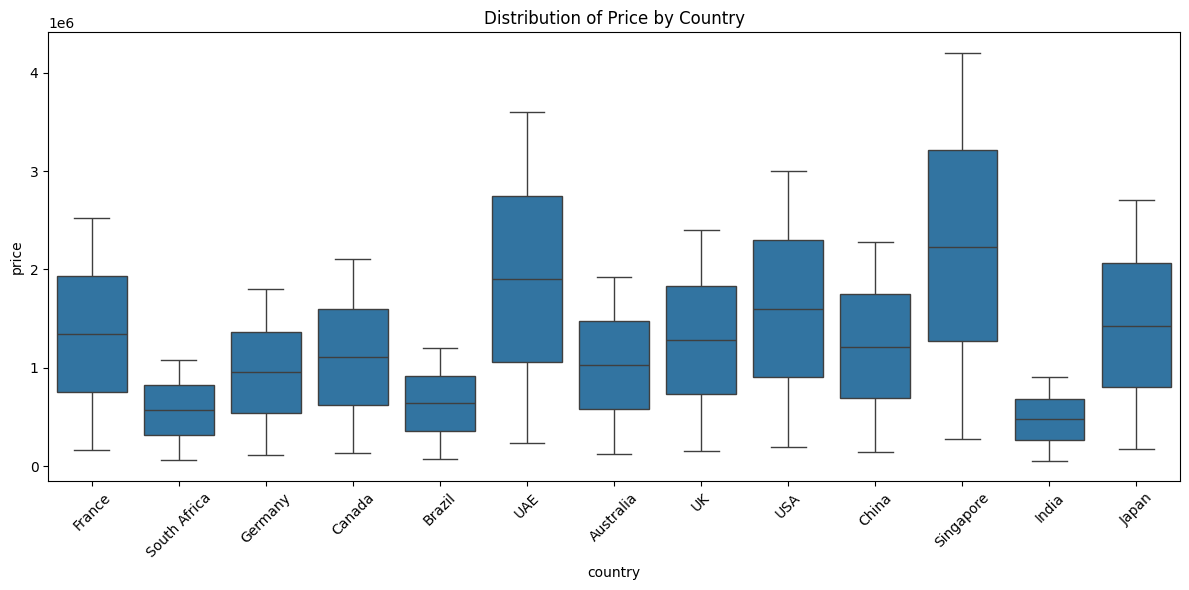

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cat_cols, x='country', y='price')
plt.xticks(rotation=45)
plt.title('Distribution of Price by Country')
plt.tight_layout()
plt.show()

Можно заметить, что стоимость сильно зависит от страны, в которой находится недвижимость, теперь зафиксируем значение страны и оценим стат. характеристики переменной для различных городов.
Рассмотрим Францию

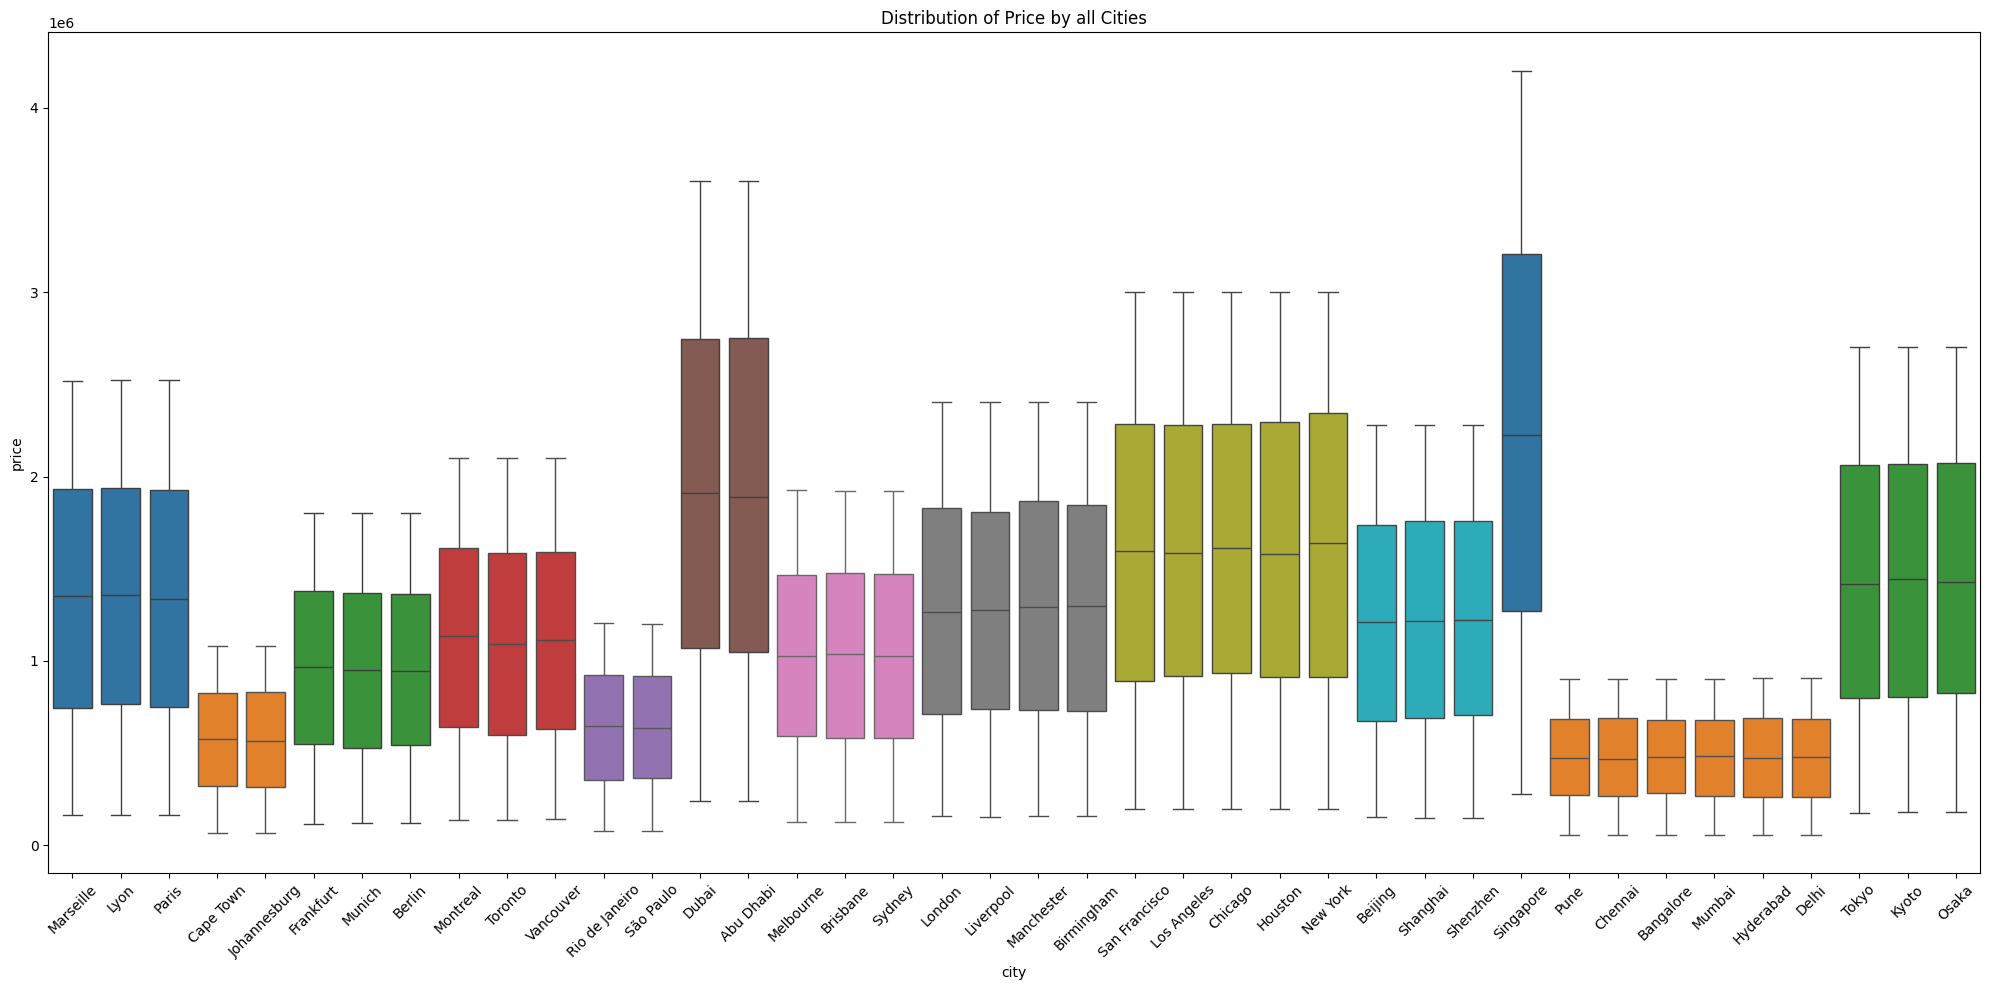

In [ ]:
fig, axes = plt.subplots(figsize=(20, 10))
def box_for_city(country):
  sns.boxplot(data=cat_cols[cat_cols['country'] == country], x='city', y='price')
  plt.xticks(rotation=45)
  plt.title(f'Distribution of Price by all Cities')
  plt.tight_layout()


for elem in cat_cols['country'].unique():
  box_for_city(elem)
plt.show()

На визуализации каждый отдлельный цвет группирует одну страну из выборки
Можно заметить, что средние и межквартильные размахи незначительно отличаются в рамках одной страны, можем допустить, что один из признаков можно будет упустить из рассмотрения, однако для подобных решений нужна более детальная оценка

 Рассмотрим распределние значений переменной типа жилья и статус мебелировки, количественно в датасете классы каждого из типов сбалансированы. Также построим ящик с усами, что бы оценить средние и размахи каждой из групп

In [12]:
cat_cols['property_type'].value_counts()

,count
property_type,
Farmhouse,33518
Apartment,33398
Townhouse,33395
Villa,33347
Independent House,33334
Studio,33008


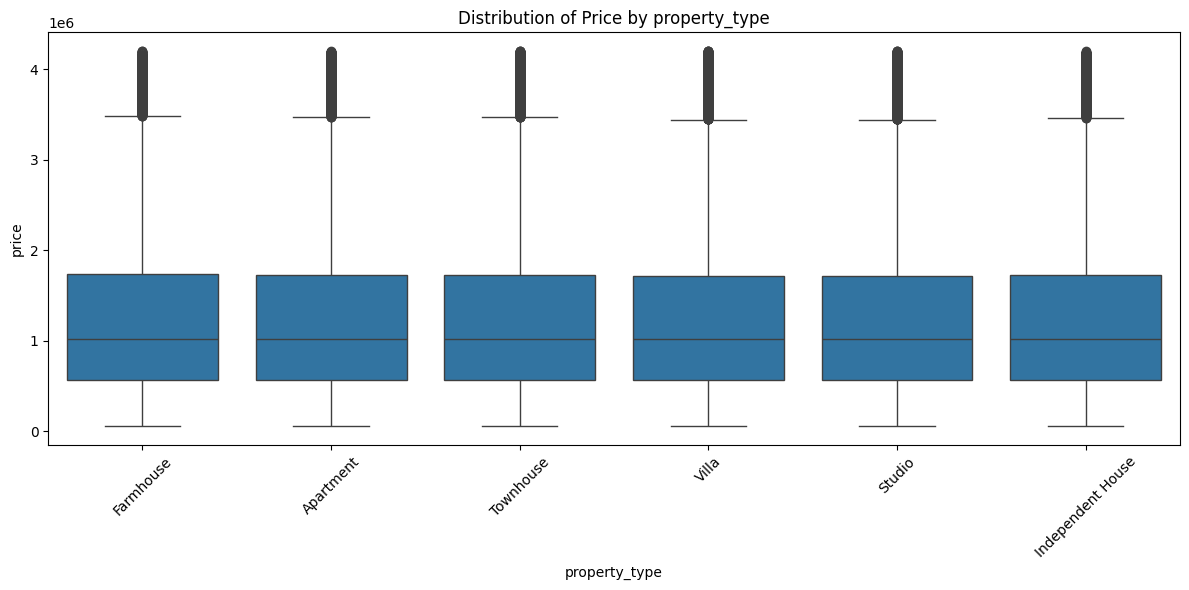

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cat_cols, x='property_type', y='price')
plt.xticks(rotation=45)
plt.title('Distribution of Price by property_type')
plt.tight_layout()
plt.show()

In [13]:
cat_cols['furnishing_status'].value_counts()

,count
furnishing_status,
Fully-Furnished,66829
Semi-Furnished,66673
Unfurnished,66498


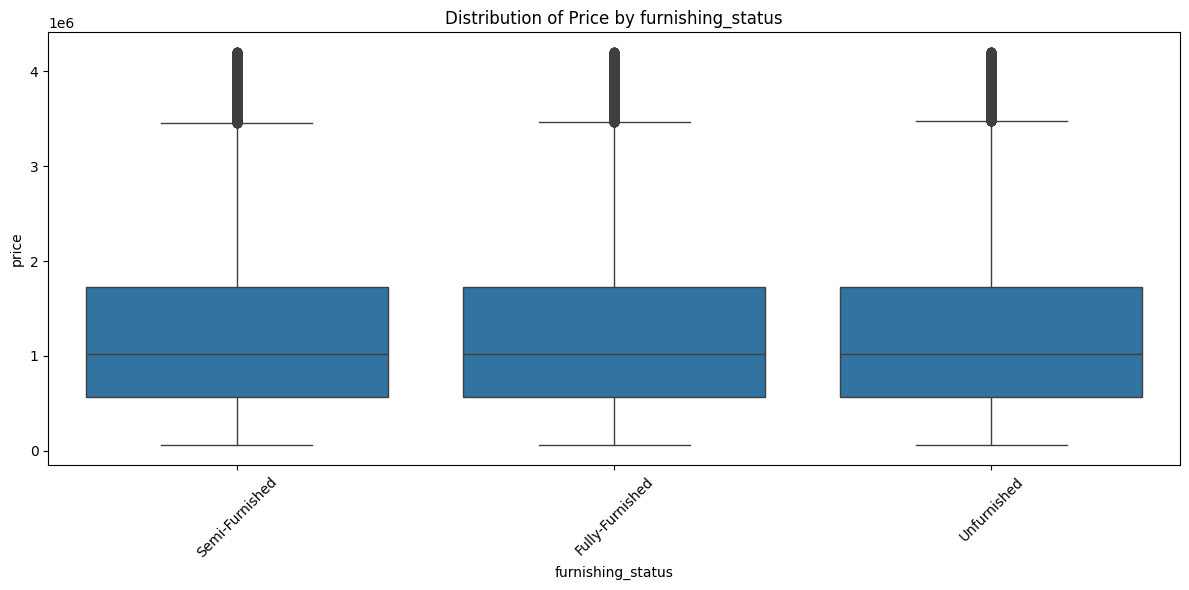

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cat_cols, x='furnishing_status', y='price')
plt.xticks(rotation=45)
plt.title('Distribution of Price by furnishing_status')
plt.tight_layout()
plt.show()

Из анализа признаков типа жилья и статуса мебелировки можно заключить, что средние значения груп, межквартильные расстояние, а также выбросы в каждой из групп идентичны. Можно предположить, что кареляция этих признаков с целевой переменной будет также низкой.

Чтобы првоерить поставленные гипотезы о степени влияниия каждого категариального признака на целевую переменную price, а также чтобы выявить возможние мультиколлиниарности признаков проведем совместный анализ категориальных и числовых признаков методом PHIK

interval columns not set, guessing: ['property_size_sqft', 'price', 'constructed_year', 'previous_owners', 'rooms', 'bathrooms', 'garage', 'garden', 'crime_cases_reported', 'legal_cases_on_property', 'satisfaction_score', 'neighbourhood_rating']


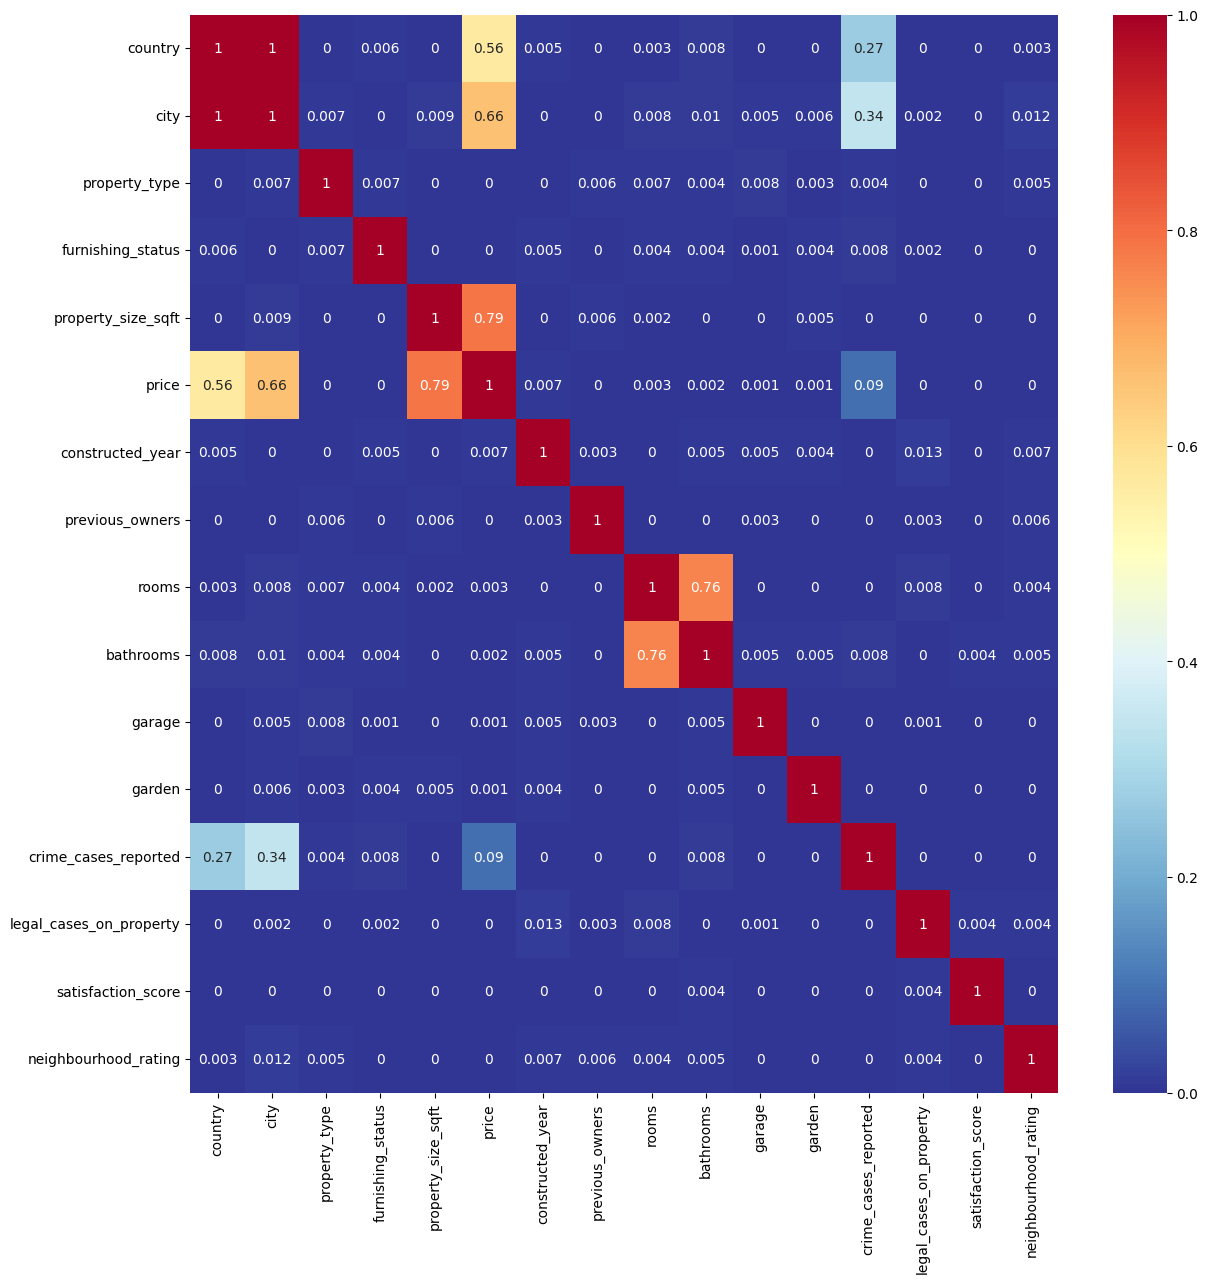

In [ ]:
plt.figure(figsize=(14, 14))
sns.heatmap(df.phik_matrix().round(3), cmap="RdYlBu_r", annot=True);

Выводы по проделанному EDA
---
- Как и ожидалось страны и города имеют единичную корриляцию между собой, необходимо выбрать один из этих признаков, более информативным является город. Так как данный признак более информативный в силу большей степени дискритизации. Также можно отметить, что признак city имеет все же большее влияния на целевую переменную, поэтому на данном этапе по результатам EDA анализа предлагается исключить из рассмотрения признак country
- Число комнат и число душевых также имееют сильную связь, что естественно
- Число криминальных случаев имеет чуть большее влияние на целевую переменную, что и предпалогалось при рассмотрении графиков зависимости переменной price от числовых признаков


----
Домашнее задание №2, Михалевич Максим Алексеевич, M4122

Для дальнейшей корректной работы с целевой переменной необходимо превести price в долларовый эквивалент, для этого напишем небольшую функцию и воспользуемся в ней открытым API (exchangerate-api) для получения актуальных курсов валют каждой их стран, рассматриваемых в датасете, по отношению к доллару. Отмечу, что результаты и метрики при воспроизведении ноутбука могут немного отличаться в связи с денамичным значениием курса различных валют к долдару

In [14]:
import requests

def get_currency_rates():
    countries = {
        'France': 'EUR', 'Germany': 'EUR', 'South Africa': 'ZAR',
        'Canada': 'CAD', 'Brazil': 'BRL', 'UAE': 'AED',
        'Australia': 'AUD', 'UK': 'GBP', 'USA': 'USD',
        'China': 'CNY', 'Singapore': 'SGD', 'India': 'INR', 'Japan': 'JPY'
    }

    try:
        response = requests.get('https://api.exchangerate-api.com/v4/latest/USD')
        data = response.json()

        rates = {}
        for country, currency in countries.items():
            if currency in data['rates']:
                rates[country] = data['rates'][currency]

        return pd.DataFrame(list(rates.items()), columns=['country', 'Rate_to_USD'])

    except:
        return "Ошибка получения данных"

currency_rates = get_currency_rates()
print(currency_rates)

         country  Rate_to_USD
0         France        0.868
1        Germany        0.868
2   South Africa       17.350
3         Canada        1.410
4         Brazil        5.340
5            UAE        3.670
6      Australia        1.550
7             UK        0.764
8            USA        1.000
9          China        7.110
10     Singapore        1.310
11         India       89.450
12         Japan      156.760


In [15]:
df_current = pd.merge(df, currency_rates, how='left', on='country')
df_current['current_price'] = df_current['price'] / df_current['Rate_to_USD']
df_current

,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,bathrooms,garage,garden,crime_cases_reported,legal_cases_on_property,satisfaction_score,neighbourhood_rating,Rate_to_USD,current_price
0,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,2,1,1,1,0,1,5,0.868,4.757316e+05
1,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,8,1,1,1,1,9,1,17.350,1.294167e+04
2,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,1,1,1,0,0,6,8,17.350,4.294548e+04
3,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,3,0,1,0,0,2,6,0.868,1.279907e+06
4,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,3,1,1,3,1,3,3,17.350,5.708415e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,Germany,Berlin,Villa,Fully-Furnished,685,203328,1968,1,3,2,0,0,1,0,8,4,0.868,2.342488e+05
199996,China,Shenzhen,Townhouse,Unfurnished,3818,1454627,1977,5,7,5,1,1,1,0,7,10,7.110,2.045889e+05
199997,Japan,Kyoto,Villa,Semi-Furnished,3603,1619147,1990,2,4,4,1,1,1,0,5,3,156.760,1.032883e+04
199998,South Africa,Johannesburg,Apartment,Unfurnished,1706,306165,2010,0,4,1,1,0,0,1,6,10,17.350,1.764640e+04


Для дальнейшей работы необходимо произвести кодировку категориальных признаков. Воспользуемся методом one-hot encoding для решения данной задачи. Учитывая разнообразность различных городов и отсутвия четкого понимания лучше ли один город, че другой, one-hot кодирование является наилучшим вариантом, не добавляющм в будущую модель лишней информации, что могло бы случиться при Ordinl или Label encoding. Также, вспоминая выводы из EDA, исключим из рассмотрения признак country

In [16]:
from sklearn.preprocessing import OneHotEncoder

ohe_encoder = OneHotEncoder(sparse_output=False)
encoded_array = ohe_encoder.fit_transform(df_current[['city', 'property_type', 'furnishing_status']])

encoded_df = pd.DataFrame(
    encoded_array,
    columns=ohe_encoder.get_feature_names_out(['city', 'property_type', 'furnishing_status'])
)

In [15]:
encoded_df

,city_Abu Dhabi,city_Bangalore,city_Beijing,city_Berlin,city_Birmingham,city_Brisbane,city_Cape Town,city_Chennai,city_Chicago,city_Delhi,...,city_Vancouver,property_type_Apartment,property_type_Farmhouse,property_type_Independent House,property_type_Studio,property_type_Townhouse,property_type_Villa,furnishing_status_Fully-Furnished,furnishing_status_Semi-Furnished,furnishing_status_Unfurnished
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
199996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
199997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
199998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Соединим два датафрейма
1) числовые признаки оставленные в рассмотрении после EDA
2) закодированные категориальные признаки

In [17]:
num_cols = df_current.select_dtypes(exclude='object')
df_for_model = pd.concat([df_current[num_cols.columns], encoded_df], axis=1)
df_for_model = df_for_model.drop(columns= ['price', 'Rate_to_USD'])
df_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 61 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   property_size_sqft                 200000 non-null  int64  
 1   constructed_year                   200000 non-null  int64  
 2   previous_owners                    200000 non-null  int64  
 3   rooms                              200000 non-null  int64  
 4   bathrooms                          200000 non-null  int64  
 5   garage                             200000 non-null  int64  
 6   garden                             200000 non-null  int64  
 7   crime_cases_reported               200000 non-null  int64  
 8   legal_cases_on_property            200000 non-null  int64  
 9   satisfaction_score                 200000 non-null  int64  
 10  neighbourhood_rating               200000 non-null  int64  
 11  current_price                      2000

Разделим даннын на тренировочную и тестовую выборку. Затем проведем масштабирование признаков методом StandartScaler. Будем масштабировать только числовые признаки, не трогая закодированные котигориальные.

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, RobustScaler

# random_state = 42

# X_train, X_test, y_train, y_test = train_test_split(
#     df_for_model.drop('current_price', axis=1), df_for_model['current_price'],
#     test_size=0.2,
#     random_state=random_state
# )

# num_cols = df_for_model.select_dtypes('int64')

# std_scaler = StandardScaler()
# rbs_scaler = RobustScaler()
# # X_train = std_scaller.fit_transform(X_train)
# # X_test = std_scaller.transform(X_test)

# X_train_scaled = std_scaler.fit_transform(X_train[num_cols.columns])
# X_train = np.hstack([X_train_scaled, X_train.drop(num_cols.columns, axis=1).to_numpy()])
# X_test_scaled = std_scaler.transform(X_test[num_cols.columns])
# X_test = np.hstack([X_test_scaled, X_test.drop(num_cols.columns, axis=1).to_numpy()])


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
import numpy as np

random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    df_for_model.drop('current_price', axis=1),
    df_for_model['current_price'],
    test_size=0.2,
    random_state=random_state
)

X_train_original = X_train.copy()
X_test_original = X_test.copy()

num_cols = df_for_model.select_dtypes('int64')

std_scaler = StandardScaler()
rbs_scaler = RobustScaler()

X_train_scaled = std_scaler.fit_transform(X_train[num_cols.columns])
X_test_scaled = std_scaler.transform(X_test[num_cols.columns])


scaled_columns = [f'{col}_scaled' for col in num_cols.columns]
categorical_columns = X_train.drop(num_cols.columns, axis=1).columns.tolist()

X_train = pd.DataFrame(
    np.hstack([X_train_scaled, X_train.drop(num_cols.columns, axis=1)]),
    columns=scaled_columns + categorical_columns,
    index=X_train.index
)

X_test = pd.DataFrame(
    np.hstack([X_test_scaled, X_test.drop(num_cols.columns, axis=1)]),
    columns=scaled_columns + categorical_columns,
    index=X_test.index
)

print("Форма X_train_df:", X_train.shape)
print("Форма X_test_df:", X_test.shape)
print("\nНазвания признаков:")
print(X_train.columns.tolist())

Форма X_train_df: (160000, 60)
Форма X_test_df: (40000, 60)

Названия признаков:
['property_size_sqft_scaled', 'constructed_year_scaled', 'previous_owners_scaled', 'rooms_scaled', 'bathrooms_scaled', 'garage_scaled', 'garden_scaled', 'crime_cases_reported_scaled', 'legal_cases_on_property_scaled', 'satisfaction_score_scaled', 'neighbourhood_rating_scaled', 'city_Abu Dhabi', 'city_Bangalore', 'city_Beijing', 'city_Berlin', 'city_Birmingham', 'city_Brisbane', 'city_Cape Town', 'city_Chennai', 'city_Chicago', 'city_Delhi', 'city_Dubai', 'city_Frankfurt', 'city_Houston', 'city_Hyderabad', 'city_Johannesburg', 'city_Kyoto', 'city_Liverpool', 'city_London', 'city_Los Angeles', 'city_Lyon', 'city_Manchester', 'city_Marseille', 'city_Melbourne', 'city_Montreal', 'city_Mumbai', 'city_Munich', 'city_New York', 'city_Osaka', 'city_Paris', 'city_Pune', 'city_Rio de Janeiro', 'city_San Francisco', 'city_Shanghai', 'city_Shenzhen', 'city_Singapore', 'city_Sydney', 'city_São Paulo', 'city_Tokyo', 'ci

Теперь расчитаем метрику MAPE при условии простого прогнозирования методом взятия среднего, медиального и модального значения распределния таргетной переменной price

In [19]:
from sklearn.metrics import mean_absolute_percentage_error

avg_predict = np.full(y_test.shape[0], y_train.mean())
mape_avg = mean_absolute_percentage_error(y_test, avg_predict)

mode_predict = np.full(y_test.shape[0], y_train.mode().mean())
mape_mode = mean_absolute_percentage_error(y_test, mode_predict)

median_predict = np.full(y_test.shape[0], y_train.median())
mape_median = mean_absolute_percentage_error(y_test, median_predict)


print(f"MAPE average: {mape_avg:.4f} или {mape_avg*100:.2f}%")
print(f"MAPE avg(mode): {mape_mode:.4f} или {mape_mode*100:.2f}%")
print(f"MAPE median: {mape_median:.4f} или {mape_median*100:.2f}%")

MAPE average: 31.2705 или 3127.05%
MAPE avg(mode): 7.0000 или 700.00%
MAPE median: 18.4035 или 1840.35%


Лучший скор удалось выбить именно моде. Можно сделать выводы о том, что наш таргет имеет достаточное количество выбросов, либо высокую дисперсию, что не позволяет среднему значению хорошо справиться с описанием всех данных.
Стоит и сделать поправку на высчитываение именно MAPE, сильный взрыв среднего значения на выборсах, мог сильно исказить оценку. Для более целостного понимания картины, стоит оценить прогнозы средним, медианой и модой еще одной другой метрикой. Воспользуемся RMSE.

In [20]:
from sklearn.metrics import root_mean_squared_error

rmse_avg = root_mean_squared_error(y_test, avg_predict)
rmse_mode = root_mean_squared_error(y_test, mode_predict)
rmse_median = root_mean_squared_error(y_test, median_predict)

print(f"RMSE average: {rmse_avg:.4f}")
print(f"RMSE mode: {rmse_mode:.4f}")
print(f"RMSE median: {rmse_median:.4f}")

RMSE average: 833091.9786
RMSE mode: 1022537.8475
RMSE median: 888943.8016


метрика RMSE уже чуть сближает между собой значения полученные разными статистическими агрегациями и говорит, что в среднем такой простой метод предсказания стоимости жилья будет ошибаться на 850 тысяч долларов. Данный результат прогноза точно нельзя назвать удавлетворительным, поэтому построим чуть усложненныую линейную модель  

Построим модель класической линейной регрессии, так как во время EDA были выявлены некоторые линейные зависимости между переменными. Данный подход должен снизить ошибки на выбранной нами метрике качества

In [21]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

linear_prediction = regressor.predict(X_test)
print(f'MAPE lin.reg: {mean_absolute_percentage_error(linear_prediction, y_test):.4f} или {mean_absolute_percentage_error(linear_prediction, y_test)*100:.2f}%')
print(f'RMSE lin.reg: {root_mean_squared_error(linear_prediction, y_test):.4f}')

MAPE lin.reg: 1.3850 или 138.50%
RMSE lin.reg: 334134.7961


Также расчитаем коэфициент детерминаци, чтобы иметь представления насколько далеко от идеального решения построенное алгоритмом регрессии линейное приближение

In [23]:
from sklearn.metrics import r2_score

print(f'R2 score: {r2_score(linear_prediction, y_test)}')

R2 score: 0.8090783356552778


Линейная регрессия показала явно лучшие результаты по сравнению со статическим предсказанием статистическими методами, однако качество неоптимально, в первую очередь это связано с неспособностью модели учитывать никакие эффекты за исключением линейных. Далее необходимо будет поробовать учесть и неленейые зависимости между признаками и целевой переменной. Построить простое единичное дерево решений для задачи регрессии или ансаблевую модель случайного леса или градиентого бустинга

----
Домашнее задание №3, Михалевич Максим Алексеевич, M4122

Как уже было упомянуто ранее, данные имеют явно не только ленейные зависимости, поэтому логичным решением будет улсожнение архитектуры модели путем ипользования нелинейных вариантов. Начем с простого дерева решений, а дальше попробуем использовать подходы ансамблирования.

In [26]:
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor(random_state=random_state)
tree_regressor.fit(X_train, y_train)

tree_prediction = tree_regressor.predict(X_test)
print(f'MAPE tree: {mean_absolute_percentage_error(tree_prediction, y_test):.4f} или {mean_absolute_percentage_error(tree_prediction, y_test)*100:.2f}%')
print(f'RMSE tree: {root_mean_squared_error(tree_prediction, y_test):.4f}')
print(f'R2 score: {r2_score(tree_prediction, y_test)}')

MAPE tree: 0.0055 или 0.55%
RMSE tree: 3306.8697
R2 score: 0.9999842432785322


In [ ]:
!pip install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 36.0 MB/s eta 0:00:00


Дерево решений справилось сильно лучше классической линейной модели, попробуем еще усложнить архитектуру воспользовавшись ансаблевыми методами бэггинга и бустинга. Обучим модели с дефолтными параметрами, а затем запустим более масштбаный экспиремент с использованием optuna для перебора гиперпарамтеров моделей. Будет оптимизировать решение по выбранной в самого начала метрике MAPE, также провдеем дополнительну оптимизацию по R2, который используется в исследовании в качестве индикатора качества полученного результата относительно идеальной разршающей способности модели.

Оптимизироаться будет следующий список параметров
- 'n_estimators'
- 'max_depth'
- 'min_samples_split'
- 'min_samples_leaf'
- 'max_features'
- 'bootstrap'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from optuna import create_study, Trial
import warnings
warnings.filterwarnings('ignore')


models_quick = {
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=random_state),
    'XGBoost': xgb.XGBRegressor(n_estimators=50, random_state=random_state),
    'LightGBM': lgb.LGBMRegressor(n_estimators=50, verbose=0, random_state=random_state),
    'CatBoost': CatBoostRegressor(iterations=50, verbose=False, random_state=random_state)
}

results = []
for name, model in models_quick.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

    print(f"{name}:")
    print(f"  R² = {r2}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAPE = {mape:.4f} или {mape*100:.2f}%")
    print("-" * 40)

Random Forest:
  R² = 0.9999912080963844
  RMSE = 2470.1772
  MAPE = 0.0042 или 0.42%
----------------------------------------
XGBoost:
  R² = 0.99693444281466
  RMSE = 46125.5297
  MAPE = 1.1376 или 113.76%
----------------------------------------
LightGBM:
  R² = 0.9959863610340307
  RMSE = 52778.3498
  MAPE = 1.9839 или 198.39%
----------------------------------------
CatBoost:
  R² = 0.994623410394994
  RMSE = 61085.7765
  MAPE = 2.3515 или 235.15%
----------------------------------------


[I 2025-11-21 12:31:05,598] A new study created in memory with name: no-name-ed9f45cc-1d22-4750-8f04-c03a3150addf


Форма обучающих данных: (160000, 60)
Форма тестовых данных: (40000, 60)
Диапазон целевой переменной: [634.37, 3207566.41]
Начинаем оптимизацию гиперпараметров по MAPE...

1. Оптимизация Random Forest по MAPE...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-21 12:31:31,491] Trial 0 finished with value: 15.163453546766059 and parameters: {'n_estimators': 144, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 15.163453546766059.
[I 2025-11-21 12:34:05,138] Trial 1 finished with value: 9.779104238833956 and parameters: {'n_estimators': 211, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 9.779104238833956.
[I 2025-11-21 12:34:34,254] Trial 2 finished with value: 14.563141046682835 and parameters: {'n_estimators': 68, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 9.779104238833956.
[I 2025-11-21 12:37:29,065] Trial 3 finished with value: 7.49809575385517 and parameters: {'n_estimators': 145, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None

[I 2025-11-21 13:15:31,786] A new study created in memory with name: no-name-bdda10bd-67e7-48c9-b113-d41d0c084822


[I 2025-11-21 13:15:31,781] Trial 24 finished with value: 6.121726282821834 and parameters: {'n_estimators': 66, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 17 with value: 6.121723421182792.

2. Оптимизация XGBoost по MAPE...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-21 13:15:34,775] Trial 0 finished with value: 4.995174436907695 and parameters: {'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.09402314421302577, 'subsample': 0.7800561621019966, 'colsample_bytree': 0.8269794779654784, 'reg_alpha': 0.09375907071631495, 'reg_lambda': 0.25856476270202333}. Best is trial 0 with value: 4.995174436907695.
[I 2025-11-21 13:15:40,114] Trial 1 finished with value: 0.19398819785007176 and parameters: {'n_estimators': 123, 'max_depth': 12, 'learning_rate': 0.2910527163488437, 'subsample': 0.9421327287119844, 'colsample_bytree': 0.7638197384730123, 'reg_alpha': 0.11817759147440043, 'reg_lambda': 0.3245992204183594}. Best is trial 1 with value: 0.19398819785007176.
[I 2025-11-21 13:15:51,126] Trial 2 finished with value: 0.5428123696048327 and parameters: {'n_estimators': 299, 'max_depth': 11, 'learning_rate': 0.21251811292719042, 'subsample': 0.6334637872467787, 'colsample_bytree': 0.7362135031226466, 'reg_alpha': 0.4607821543346533, 'reg_lam

[I 2025-11-21 13:19:01,009] A new study created in memory with name: no-name-899e9841-a2c7-4f87-8418-6117e28d7b13


[I 2025-11-21 13:19:01,005] Trial 24 finished with value: 0.05036940674226056 and parameters: {'n_estimators': 172, 'max_depth': 15, 'learning_rate': 0.2776169907821246, 'subsample': 0.8989586849558054, 'colsample_bytree': 0.9169253110043483, 'reg_alpha': 0.09842323747415373, 'reg_lambda': 0.6430562709699059}. Best is trial 21 with value: 0.012035953014797153.

3. Оптимизация LightGBM по MAPE...


  0%|          | 0/25 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 60
[LightGBM] [Info] Start training from score 766706.681716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-11-21 13:19:02,279] Trial 0 finished with value: 1.820374829888298 and parameters: {'n_estimators': 101, 'max_depth': 10, 'learning_rate': 0.19436807370097237, 'num_leaves': 30, 'subsample': 0.6951641461330162, 'colsample_bytree': 0.6232321989966141, 'reg_alpha': 0.8779933930798145, 'reg_lambda': 0.7561440782331137}. Best is trial 0 with value: 1.820374829888298.
[LightGBM] [Warning] Found whitespace in feature_

[I 2025-11-21 13:20:03,522] A new study created in memory with name: no-name-234ce8b8-ad62-46e8-9a05-5e29d642d6a5


[I 2025-11-21 13:20:03,520] Trial 24 finished with value: 0.2728328110548074 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.17431512515129438, 'num_leaves': 99, 'subsample': 0.8789020137526148, 'colsample_bytree': 0.9634603089057204, 'reg_alpha': 0.8711251337666065, 'reg_lambda': 0.6154297498280428}. Best is trial 22 with value: 0.08377889990520751.

4. Оптимизация CatBoost по MAPE...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-21 13:20:08,513] Trial 0 finished with value: 0.7349132877688591 and parameters: {'iterations': 240, 'depth': 6, 'learning_rate': 0.2917202461841111, 'l2_leaf_reg': 2.370344898275327, 'random_strength': 0.4098418512199913, 'bagging_temperature': 0.40616626115911336}. Best is trial 0 with value: 0.7349132877688591.
[I 2025-11-21 13:20:12,739] Trial 1 finished with value: 2.7964562494108236 and parameters: {'iterations': 152, 'depth': 5, 'learning_rate': 0.13586678452334292, 'l2_leaf_reg': 7.496513458677055, 'random_strength': 0.2819865236746544, 'bagging_temperature': 0.013367365176043311}. Best is trial 0 with value: 0.7349132877688591.
[I 2025-11-21 13:20:14,599] Trial 2 finished with value: 2.765889740665207 and parameters: {'iterations': 63, 'depth': 7, 'learning_rate': 0.20837944449214538, 'l2_leaf_reg': 1.751889483693625, 'random_strength': 0.5959493942124635, 'bagging_temperature': 0.9666847748330246}. Best is trial 0 with value: 0.7349132877688591.
[I 2025-11-21 13:20

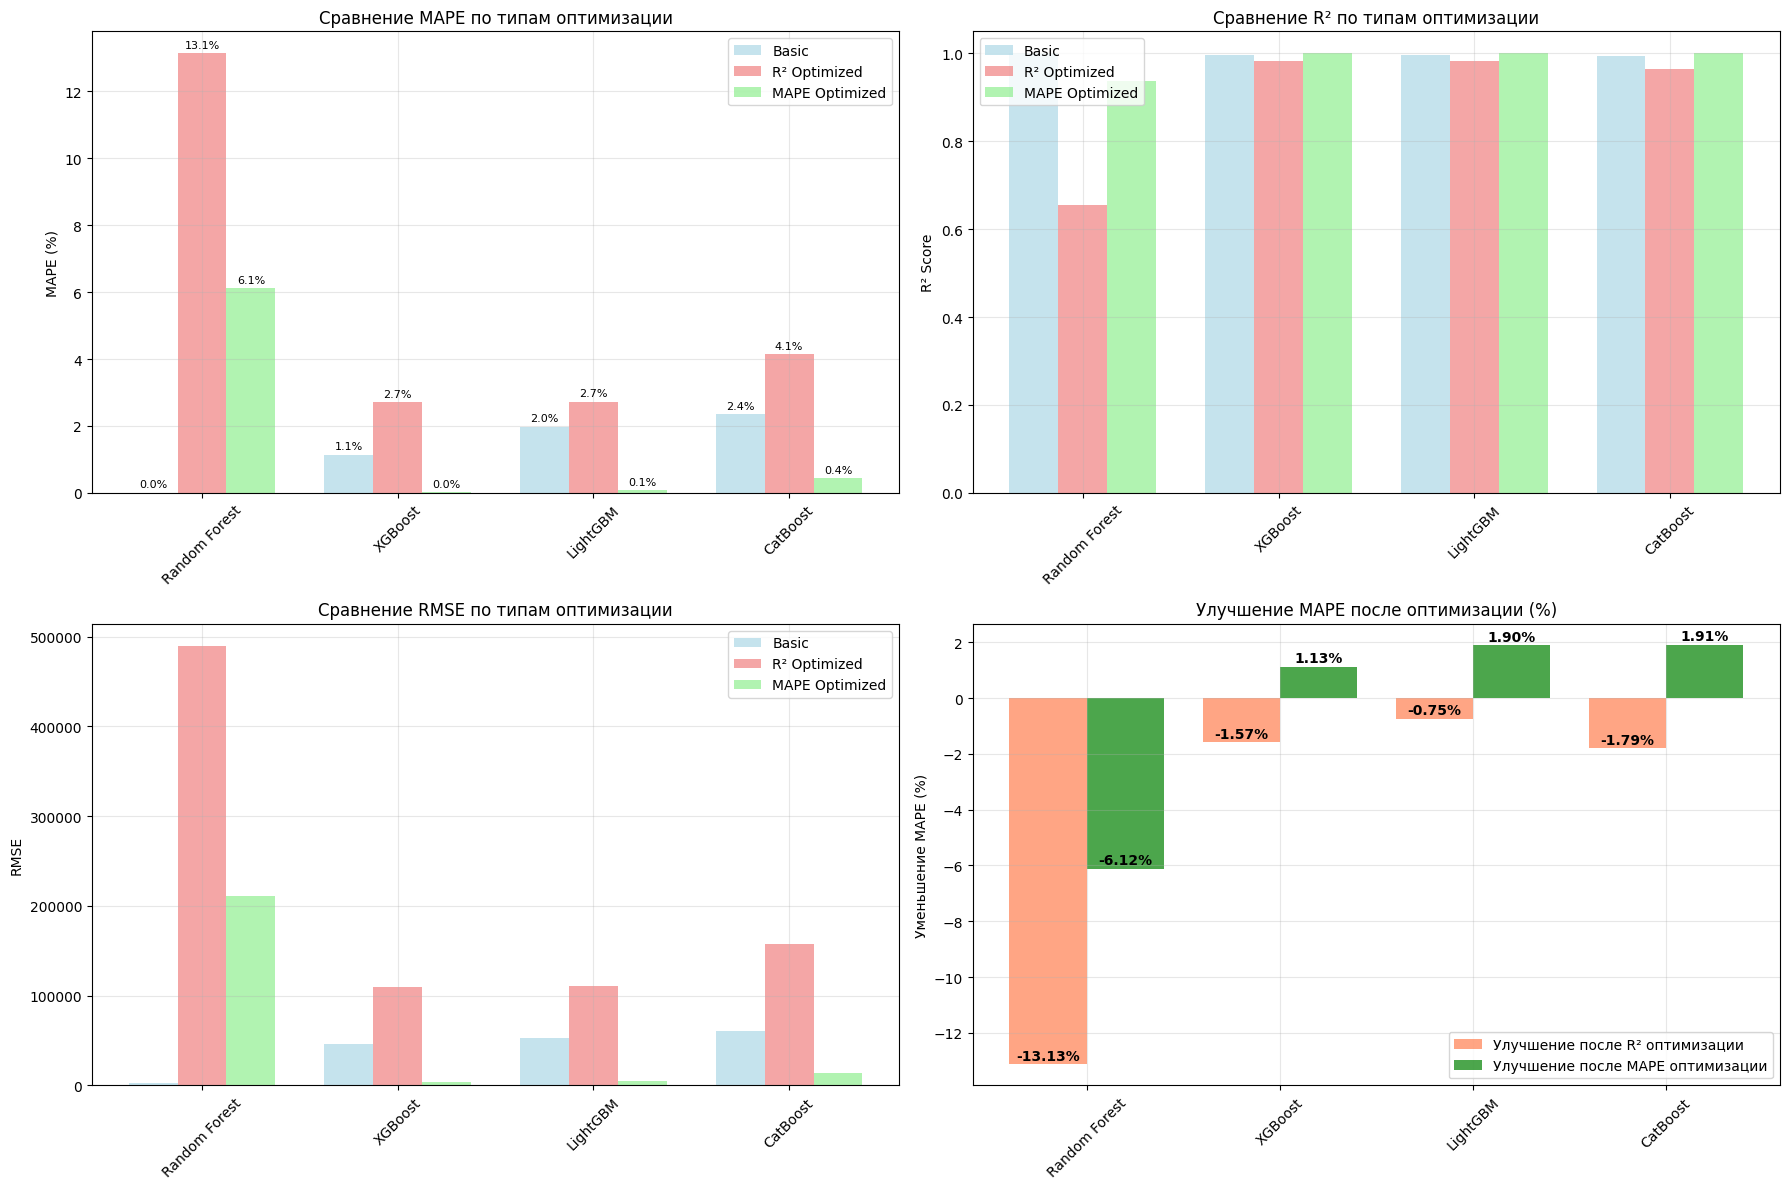

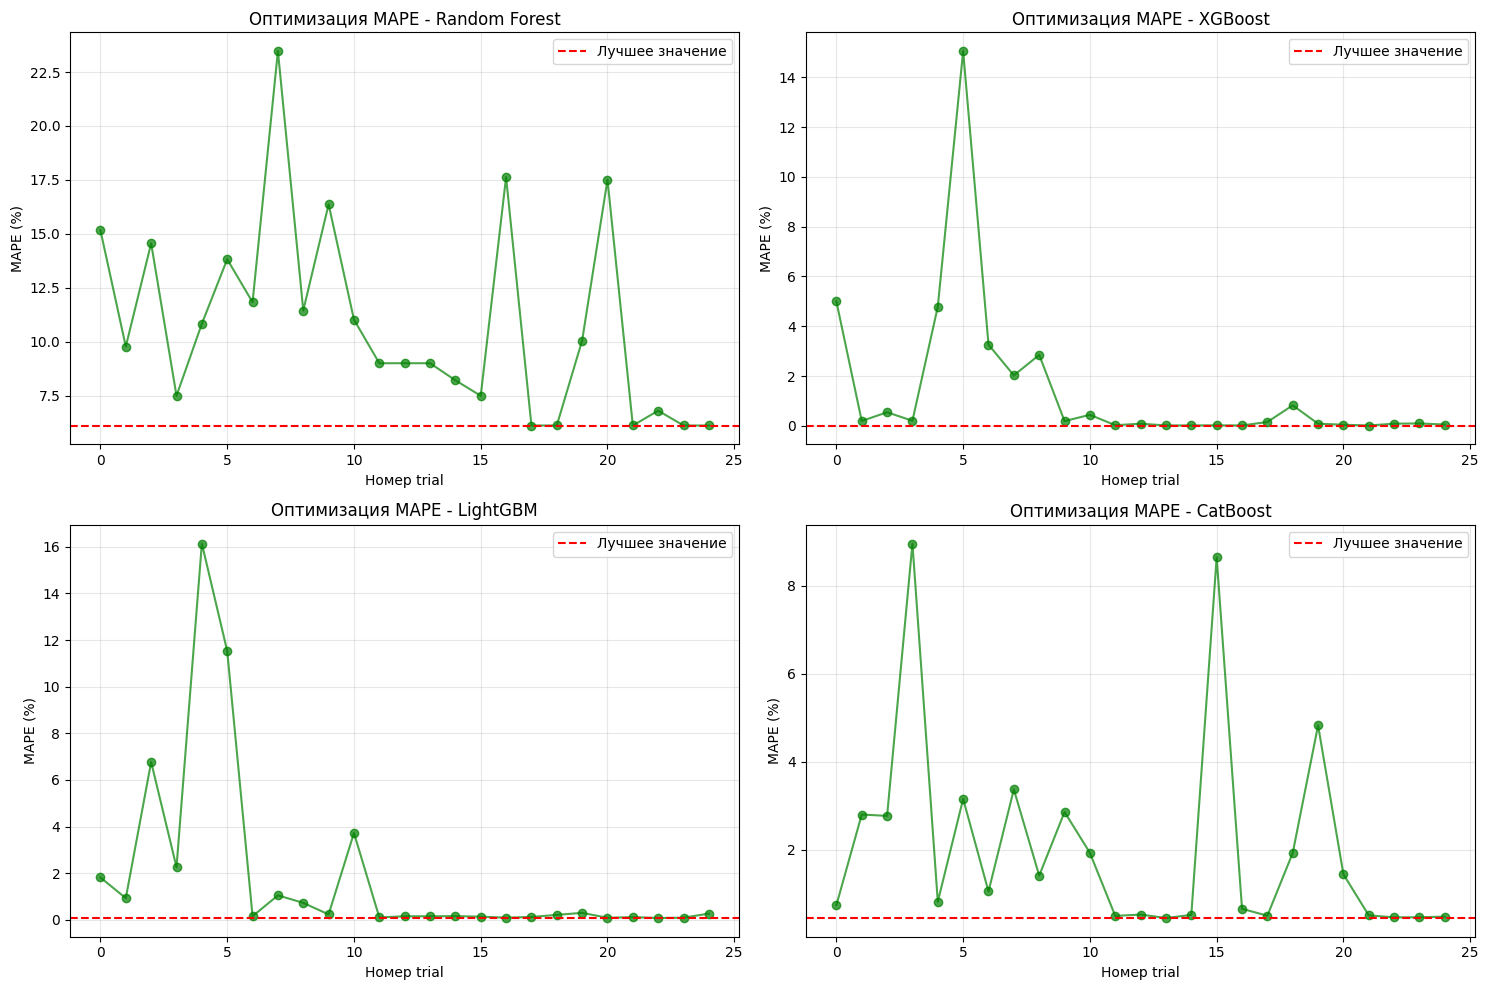


АНАЛИЗ ЭФФЕКТИВНОСТИ ОПТИМИЗАЦИИ ПО MAPE:

Топ-3 модели по MAPE:
1. Random Forest (Basic): MAPE = 0.0042%, R² = 1.0000
2. XGBoost (MAPE Opt): MAPE = 0.0120%, R² = 1.0000
3. LightGBM (MAPE Opt): MAPE = 0.0838%, R² = 1.0000

Сравнение эффективности оптимизации:

Random Forest:
  Basic MAPE: 0.0042%
  R² Opt MAPE: 13.1369% (улучшение: -13.1328%)
  MAPE Opt MAPE: 6.1217% (улучшение: -6.1175%)
  MAPE оптимизация лучше на: 7.0152%

XGBoost:
  Basic MAPE: 1.1376%
  R² Opt MAPE: 2.7094% (улучшение: -1.5717%)
  MAPE Opt MAPE: 0.0120% (улучшение: 1.1256%)
  MAPE оптимизация лучше на: 2.6973%

LightGBM:
  Basic MAPE: 1.9839%
  R² Opt MAPE: 2.7301% (улучшение: -0.7462%)
  MAPE Opt MAPE: 0.0838% (улучшение: 1.9001%)
  MAPE оптимизация лучше на: 2.6463%

CatBoost:
  Basic MAPE: 2.3515%
  R² Opt MAPE: 4.1441% (улучшение: -1.7926%)
  MAPE Opt MAPE: 0.4427% (улучшение: 1.9088%)
  MAPE оптимизация лучше на: 3.7014%

ЛУЧШАЯ МОДЕЛЬ В ЦЕЛОМ: Random Forest (Basic)
MAPE: 0.0042%
R²: 1.0000
RMSE: 2470.1772


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.datasets import make_regression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from optuna import create_study, Trial
import warnings
warnings.filterwarnings('ignore')


X_train_s, X_test_s, y_train_s, y_test_s = X_train, X_test, y_train, y_test

print(f"Форма обучающих данных: {X_train_s.shape}")
print(f"Форма тестовых данных: {X_test_s.shape}")
print(f"Диапазон целевой переменной: [{y_test_s.min():.2f}, {y_test_s.max():.2f}]")



def objective_rf_mape(trial: Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    model = RandomForestRegressor(**params, random_state=random_state, n_jobs=-1)
    model.fit(X_train_s, y_train_s)
    y_pred = model.predict(X_test_s)
    mape = mean_absolute_percentage_error(y_test_s, y_pred)
    return mape


def objective_xgb_mape(trial: Trial):
    """Целевая функция для XGBoost (минимизация MAPE)"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }

    model = xgb.XGBRegressor(**params, random_state=random_state, n_jobs=-1)
    model.fit(X_train_s, y_train_s)
    y_pred = model.predict(X_test_s)
    mape = mean_absolute_percentage_error(y_test_s, y_pred)
    return mape


def objective_lgb_mape(trial: Trial):
    """Целевая функция для LightGBM (минимизация MAPE)"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }

    model = lgb.LGBMRegressor(**params, random_state=random_state, n_jobs=-1)
    model.fit(X_train_s, y_train_s)
    y_pred = model.predict(X_test_s)
    mape = mean_absolute_percentage_error(y_test_s, y_pred)
    return mape


def objective_catboost_mape(trial: Trial):
    """Целевая функция для CatBoost (минимизация MAPE)"""
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1)
    }

    model = CatBoostRegressor(**params, random_state=random_state, verbose=False)
    model.fit(X_train_s, y_train_s)
    y_pred = model.predict(X_test_s)
    mape = mean_absolute_percentage_error(y_test_s, y_pred)
    return mape


print("Начинаем оптимизацию гиперпараметров по MAPE...")


print("\n1. Оптимизация Random Forest по MAPE...")
study_rf_mape = create_study(direction='minimize')
study_rf_mape.optimize(objective_rf_mape, n_trials=25, show_progress_bar=True)
best_rf_params_mape = study_rf_mape.best_params


print("\n2. Оптимизация XGBoost по MAPE...")
study_xgb_mape = create_study(direction='minimize')
study_xgb_mape.optimize(objective_xgb_mape, n_trials=25, show_progress_bar=True)
best_xgb_params_mape = study_xgb_mape.best_params


print("\n3. Оптимизация LightGBM по MAPE...")
study_lgb_mape = create_study(direction='minimize')
study_lgb_mape.optimize(objective_lgb_mape, n_trials=25, show_progress_bar=True)
best_lgb_params_mape = study_lgb_mape.best_params


print("\n4. Оптимизация CatBoost по MAPE...")
study_catboost_mape = create_study(direction='minimize')
study_catboost_mape.optimize(objective_catboost_mape, n_trials=25, show_progress_bar=True)
best_catboost_params_mape = study_catboost_mape.best_params


print("\n" + "="*60)
print("ЛУЧШИЕ ПАРАМЕТРЫ ДЛЯ КАЖДОЙ МОДЕЛИ (ОПТИМИЗАЦИЯ ПО MAPE):")
print("="*60)

print(f"\nRandom Forest: {best_rf_params_mape}")
print(f"Лучший MAPE: {study_rf_mape.best_value:.4f}%")

print(f"\nXGBoost: {best_xgb_params_mape}")
print(f"Лучший MAPE: {study_xgb_mape.best_value:.4f}%")

print(f"\nLightGBM: {best_lgb_params_mape}")
print(f"Лучший MAPE: {study_lgb_mape.best_value:.4f}%")

print(f"\nCatBoost: {best_catboost_params_mape}")
print(f"Лучший MAPE: {study_catboost_mape.best_value:.4f}%")


print("\n" + "="*60)
print("ОБУЧЕНИЕ МОДЕЛЕЙ С ЛУЧШИМИ ПАРАМЕТРАМИ (MAPE):")
print("="*60)

models_optimized_mape = {
    'Random Forest (MAPE Opt)': RandomForestRegressor(**best_rf_params_mape, random_state=random_state, n_jobs=-1),
    'XGBoost (MAPE Opt)': xgb.XGBRegressor(**best_xgb_params_mape, random_state=random_state, n_jobs=-1),
    'LightGBM (MAPE Opt)': lgb.LGBMRegressor(**best_lgb_params_mape, random_state=random_state, n_jobs=-1),
    'CatBoost (MAPE Opt)': CatBoostRegressor(**best_catboost_params_mape, random_state=random_state, verbose=False)
}


models_basic = {
    'Random Forest (Basic)': RandomForestRegressor(n_estimators=50, random_state=random_state),
    'XGBoost (Basic)': xgb.XGBRegressor(n_estimators=50, random_state=random_state),
    'LightGBM (Basic)': lgb.LGBMRegressor(n_estimators=50, random_state=random_state),
    'CatBoost (Basic)': CatBoostRegressor(iterations=50, verbose=False, random_state=random_state)
}


models_optimized_r2 = {
    'Random Forest (R2 Opt)': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=random_state),
    'XGBoost (R2 Opt)': xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=random_state),
    'LightGBM (R2 Opt)': lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=random_state),
    'CatBoost (R2 Opt)': CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, verbose=False, random_state=random_state)
}


all_models = {**models_basic, **models_optimized_r2, **models_optimized_mape}


print("\nСравнение моделей с разными типами оптимизации:")
results = []

for name, model in all_models.items():
    model.fit(X_train_s, y_train_s)
    y_pred = model.predict(X_test_s)

    r2 = r2_score(y_test_s, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_s, y_pred))
    mape = mean_absolute_percentage_error(y_test_s, y_pred)

    if 'MAPE Opt' in name:
        opt_type = 'MAPE Optimized'
    elif 'R2 Opt' in name:
        opt_type = 'R2 Optimized'
    else:
        opt_type = 'Basic'

    results.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'Type': opt_type
    })

    print(f"{name}:")
    print(f"  R² = {r2:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAPE = {mape:.4f}%")
    print("-" * 50)

results_df = pd.DataFrame(results)
results_df_sorted_mape = results_df.sort_values('MAPE (%)')

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ОТСОРТИРОВАНЫ ПО MAPE (ОСНОВНАЯ МЕТРИКА):")
print("="*60)
print(results_df_sorted_mape.round(4))


fig, axes = plt.subplots(2, 2, figsize=(18, 12))

basic_results = results_df[results_df['Type'] == 'Basic']
r2_opt_results = results_df[results_df['Type'] == 'R2 Optimized']
mape_opt_results = results_df[results_df['Type'] == 'MAPE Optimized']

model_names = ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
x_pos = np.arange(len(model_names))
width = 0.25

axes[0, 0].bar(x_pos - width, basic_results['MAPE (%)'], width, label='Basic', alpha=0.7, color='lightblue')
axes[0, 0].bar(x_pos, r2_opt_results['MAPE (%)'], width, label='R² Optimized', alpha=0.7, color='lightcoral')
axes[0, 0].bar(x_pos + width, mape_opt_results['MAPE (%)'], width, label='MAPE Optimized', alpha=0.7, color='lightgreen')
axes[0, 0].set_title('Сравнение MAPE по типам оптимизации')
axes[0, 0].set_ylabel('MAPE (%)')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(model_names, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


for i, (basic, r2_opt, mape_opt) in enumerate(zip(basic_results['MAPE (%)'],
                                                 r2_opt_results['MAPE (%)'],
                                                 mape_opt_results['MAPE (%)'])):
    axes[0, 0].text(i - width, basic + 0.1, f'{basic:.1f}%', ha='center', va='bottom', fontsize=8)
    axes[0, 0].text(i, r2_opt + 0.1, f'{r2_opt:.1f}%', ha='center', va='bottom', fontsize=8)
    axes[0, 0].text(i + width, mape_opt + 0.1, f'{mape_opt:.1f}%', ha='center', va='bottom', fontsize=8)

axes[0, 1].bar(x_pos - width, basic_results['R²'], width, label='Basic', alpha=0.7, color='lightblue')
axes[0, 1].bar(x_pos, r2_opt_results['R²'], width, label='R² Optimized', alpha=0.7, color='lightcoral')
axes[0, 1].bar(x_pos + width, mape_opt_results['R²'], width, label='MAPE Optimized', alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Сравнение R² по типам оптимизации')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(model_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].bar(x_pos - width, basic_results['RMSE'], width, label='Basic', alpha=0.7, color='lightblue')
axes[1, 0].bar(x_pos, r2_opt_results['RMSE'], width, label='R² Optimized', alpha=0.7, color='lightcoral')
axes[1, 0].bar(x_pos + width, mape_opt_results['RMSE'], width, label='MAPE Optimized', alpha=0.7, color='lightgreen')
axes[1, 0].set_title('Сравнение RMSE по типам оптимизации')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(model_names, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


mape_improvement_r2 = []
mape_improvement_mape = []

for model_name in model_names:
    basic_mape = basic_results[basic_results['Model'].str.contains(model_name)]['MAPE (%)'].values[0]
    r2_opt_mape = r2_opt_results[r2_opt_results['Model'].str.contains(model_name)]['MAPE (%)'].values[0]
    mape_opt_mape = mape_opt_results[mape_opt_results['Model'].str.contains(model_name)]['MAPE (%)'].values[0]

    mape_improvement_r2.append(basic_mape - r2_opt_mape)  # положительное - улучшение
    mape_improvement_mape.append(basic_mape - mape_opt_mape)

x_pos_double = np.arange(len(model_names)) * 2
width_double = 0.8

axes[1, 1].bar(x_pos_double - width_double/2, mape_improvement_r2, width_double,
               label='Улучшение после R² оптимизации', alpha=0.7, color='coral')
axes[1, 1].bar(x_pos_double + width_double/2, mape_improvement_mape, width_double,
               label='Улучшение после MAPE оптимизации', alpha=0.7, color='green')

axes[1, 1].set_title('Улучшение MAPE после оптимизации (%)')
axes[1, 1].set_ylabel('Уменьшение MAPE (%)')
axes[1, 1].set_xticks(x_pos_double)
axes[1, 1].set_xticklabels(model_names, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)


for i, (imp_r2, imp_mape) in enumerate(zip(mape_improvement_r2, mape_improvement_mape)):
    axes[1, 1].text(i*2 - width_double/2, imp_r2 + 0.05, f'{imp_r2:.2f}%',
                   ha='center', va='bottom', fontweight='bold')
    axes[1, 1].text(i*2 + width_double/2, imp_mape + 0.05, f'{imp_mape:.2f}%',
                   ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
studies_mape = [study_rf_mape, study_xgb_mape, study_lgb_mape, study_catboost_mape]
study_names = ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']

for idx, (study, name) in enumerate(zip(studies_mape, study_names)):
    axes[idx//2, idx%2].plot([t.value for t in study.trials], 'o-', alpha=0.7, color='green')
    axes[idx//2, idx%2].axhline(y=study.best_value, color='r', linestyle='--', label='Лучшее значение')
    axes[idx//2, idx%2].set_title(f'Оптимизация MAPE - {name}')
    axes[idx//2, idx%2].set_xlabel('Номер trial')
    axes[idx//2, idx%2].set_ylabel('MAPE (%)')
    axes[idx//2, idx%2].legend()
    axes[idx//2, idx%2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("АНАЛИЗ ЭФФЕКТИВНОСТИ ОПТИМИЗАЦИИ ПО MAPE:")
print("="*60)

print("\nТоп-3 модели по MAPE:")
top_3_mape = results_df_sorted_mape.head(3)
for i, (_, row) in enumerate(top_3_mape.iterrows(), 1):
    print(f"{i}. {row['Model']}: MAPE = {row['MAPE (%)']:.4f}%, R² = {row['R²']:.4f}")

print("\nСравнение эффективности оптимизации:")
for model_name in model_names:
    basic_mape = basic_results[basic_results['Model'].str.contains(model_name)]['MAPE (%)'].values[0]
    r2_opt_mape = r2_opt_results[r2_opt_results['Model'].str.contains(model_name)]['MAPE (%)'].values[0]
    mape_opt_mape = mape_opt_results[mape_opt_results['Model'].str.contains(model_name)]['MAPE (%)'].values[0]

    improvement_r2 = basic_mape - r2_opt_mape
    improvement_mape = basic_mape - mape_opt_mape

    print(f"\n{model_name}:")
    print(f"  Basic MAPE: {basic_mape:.4f}%")
    print(f"  R² Opt MAPE: {r2_opt_mape:.4f}% (улучшение: {improvement_r2:.4f}%)")
    print(f"  MAPE Opt MAPE: {mape_opt_mape:.4f}% (улучшение: {improvement_mape:.4f}%)")
    print(f"  MAPE оптимизация лучше на: {improvement_mape - improvement_r2:.4f}%")

best_overall_model = results_df_sorted_mape.iloc[0]
print(f"\n{'='*60}")
print(f"ЛУЧШАЯ МОДЕЛЬ В ЦЕЛОМ: {best_overall_model['Model']}")
print(f"MAPE: {best_overall_model['MAPE (%)']:.4f}%")
print(f"R²: {best_overall_model['R²']:.4f}")
print(f"RMSE: {best_overall_model['RMSE']:.4f}")
print(f"{'='*60}")

Реализуем еще раз модель дающее наилучшее качество. Ей по итогам экспериментов оказлся базовый случайный лес с вполне дефоотными параметрами из sklearn

In [56]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(
    n_estimators=50,
    random_state=random_state)
rf_regressor.fit(X_train, y_train)

rf_prediction = rf_regressor.predict(X_test)
print(f'MAPE tree: {mean_absolute_percentage_error(rf_prediction, y_test):.4f} или {mean_absolute_percentage_error(rf_prediction, y_test)*100:.2f}%')
print(f'RMSE tree: {root_mean_squared_error(rf_prediction, y_test):.4f}')
print(f'R2 score: {r2_score(rf_prediction, y_test)}')

MAPE tree: 0.0042 или 0.42%
RMSE tree: 2467.7563
R2 score: 0.9999912250510604


Далее выполним интерпретацию предсказаний модели, воспользуемся библиотекой shap для анализа пары конкретных семплов в данных, а далее выполним глобальную интерпретацию на первых 100 примерах и сделаем выводы о важности признаков

In [57]:
import shap

explainer = shap.TreeExplainer(rf_regressor)

In [58]:
X_test.iloc[[2477]]

,property_size_sqft_scaled,constructed_year_scaled,previous_owners_scaled,rooms_scaled,bathrooms_scaled,garage_scaled,garden_scaled,crime_cases_reported_scaled,legal_cases_on_property_scaled,satisfaction_score_scaled,...,city_Vancouver,property_type_Apartment,property_type_Farmhouse,property_type_Independent House,property_type_Studio,property_type_Townhouse,property_type_Villa,furnishing_status_Fully-Furnished,furnishing_status_Semi-Furnished,furnishing_status_Unfurnished
32581,-1.624013,-1.592648,0.001617,-1.529694,-0.956094,1.00085,-1.002015,0.650131,-0.577033,1.566362,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [59]:
choosen_instance = X_test.iloc[[2477]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [60]:
X_test.iloc[[10023]]

,property_size_sqft_scaled,constructed_year_scaled,previous_owners_scaled,rooms_scaled,bathrooms_scaled,garage_scaled,garden_scaled,crime_cases_reported_scaled,legal_cases_on_property_scaled,satisfaction_score_scaled,...,city_Vancouver,property_type_Apartment,property_type_Farmhouse,property_type_Independent House,property_type_Studio,property_type_Townhouse,property_type_Villa,furnishing_status_Fully-Furnished,furnishing_status_Semi-Furnished,furnishing_status_Unfurnished
30304,-0.116271,-1.646716,-0.497932,-1.094088,-0.956094,1.00085,0.99799,0.650131,-0.577033,-0.867763,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [61]:

choosen_instance = X_test.iloc[[10023]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

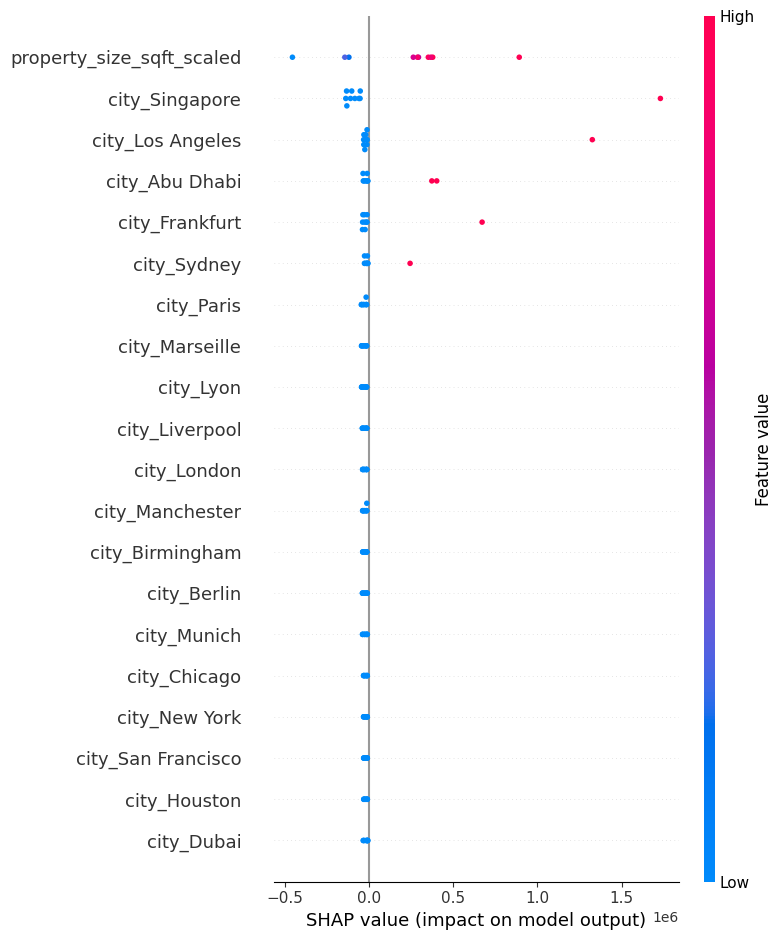

In [40]:
shap_values = explainer.shap_values(X_train.iloc[:10])
shap.summary_plot(shap_values, X_train.iloc[:10])

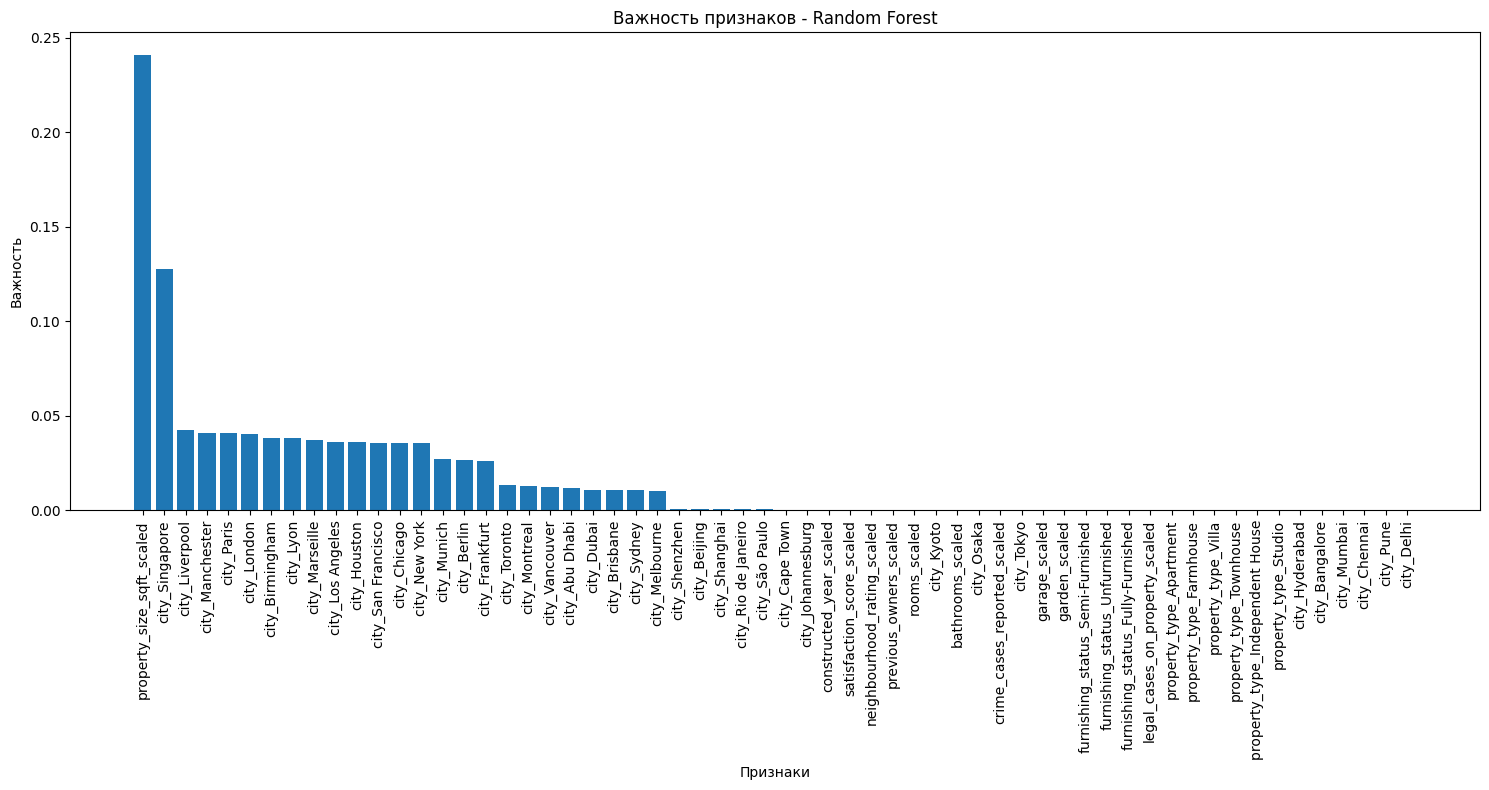

In [37]:
feature_importance = rf_regressor.feature_importances_

indices = np.argsort(feature_importance)[::-1]
features = [f'Feature {i}' for i in range(X_train.shape[1])]

plt.figure(figsize=(15, 8))
plt.bar(range(len(feature_importance)), feature_importance[indices])
plt.xticks(range(len(feature_importance)), [X_train.columns[i] for i in indices], rotation=90)
plt.title('Важность признаков - Random Forest')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.tight_layout()
plt.show()

В ходе оценки влияния признаков на результат прогноза было выявлено, что наибольшее влияние на стоимость квартиры имеет ее площадь. Также при вычислении значений Шейпли площадь всегда оказывает существенное влияние на стоймость жилья, что можно счиать вполне реалиным показателем.  

В целом же в ходе решения задачи удалось создать регриссионую модель, прогназирующую стоймость недвижимости дающую оценку с точностью до 0,42%. Корень из средней квадратичной ошибки в лучшем варианте решения был равен 2470, что означает следующее - модель в среднем ошибается в своем прогнозе стоймости на 2470 долларов исходя из обучающего набора данных